# Introduction
### The Task:
* Since I have never been to Finnland, I am courious about the difference between Finnland and Germany
* So, I constrain myself to finding the difference between those two Countries

### Approach:
* I would like to find stereotypes describing finnish and german mindsets. Therefore,
* I use models that are relatively easy to interpret
* I.e, models where no rotation in feature space occurs and which, have relatively simple decision boundaries
* Therefore I will use correlation analysis and decision trees
* Furthermore, I want to use as little as possible features to eventually build a "sterotype model".
* That is a model, which gives a rough impression of the difference between Germany and Finnland.
* Other models (random forest) I just use for the sake of feature selection


### Key findings:
* Based on the data I have selected, Germany and Finnland disciminate mainly in 
    1. how people perseive the current state of the educational system, and 
    2. the current state of the economy. 
* These features are pretty predictive ($> 90\,\%$ accuracy)

### Structure of this notebook
1. Definition of helper functions
2. Data cleaning
3. Correlation analysis
4. Feature Selection
5. The stereotype model
6. Decision Boundaries

### The Data
* European Social Survey: http://www.europeansocialsurvey.org/downloadwizard/
* Round 7 (Year 2014)
* **Features:** 

|Category |Feature Name |Description |
|-------|-----|-------------------------| 
|Media and trust |TVTOT |TV watching, total time on average weekday|
|Media and trust|TVPOL |TV watching news/politics/current affairs on average weekday|
|Media and trust|RDTOT |Radio listening total time on average weekday|
|Media and trust|RDPOL |Radio listening news/politics/current affairs on average weekday|
|Media and trust|NWSPTOT |Newspaper reading total time on average weekday|
|Media and trust|NWSPPOL |Newspaper reading politics/current affairs on average weekday|
|Media and trust|NETUSE |Personal use of internet/e-mail/www|
|Media and trust|PPLTRST |Most people can be trusted or you can't be too careful|
|Media and trust|PPLFAIR |Most people try to take advantage of you, or try to be fair|
|Media and trust|PPLHLP |Most of the time people helpful or mostly looking out for themselves|
|Politics |POLINTR |How interested in politics |
|Politics|POLCMPL |Politics too complicated to understand |
|Politics|POLDCS |Making mind up about political issues |
|Politics|TRSTPRL |Trust in country's parliament |
|Politics|TRSTLGL |Trust in the legal system |
|Politics|TRSTPLC |Trust in the police |
|Politics|TRSTPLT |Trust in politicians |
|Politics|TRSTPRT |Trust in political parties |
|Politics|TRSTEP |Trust in the European Parliament |
|Politics|STFLIFE |How satisfied with life as a whole |
|Politics|STFECO |How satisfied with present state of economy in country |
|Politics|STFGOV |How satisfied with the national government |
|Politics|STFDEM |How satisfied with the way democracy works in country |
|Politics|STFEDU |State of education in country nowadays |
|Politics|STFHLTH |State of health services in country nowadays |
|Politics|GINCDIF |Government should reduce differences in income levels |
|Politics|FREEHMS |Gays and lesbians free to live life as they wish |
|Politics|SCNSENV |Modern science can be relied on to solve environmental problems |
|Politics|EUFTF |European Union: European unification go further or gone too far |
|Politics|IMSMETN |Allow many/few immigrants of same race/ethnic group as majority |
|Politics|IMDFETN |Allow many/few immigrants of different race/ethnic group from majority |
|Politics|IMPCNTR |Allow many/few immigrants from poorer countries outside Europe |
|Politics|IMBGECO |Immigration bad or good for country's economy |
|Politics|IMUECLT |Country's cultural life undermined or enriched by immigrants |
|Politics|IMWBCNT |Immigrants make country worse or better place to live |

* No stratification weight adjustments have been made in this work

In [27]:
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
import numpy as np
from pandas import  Series
from IPython.display import display, HTML, Markdown
from matplotlib import colors
from collections import namedtuple
from sklearn import  tree
import graphviz # graphviz is kind of hard to get running - you neet to apt install it (not via pip).
import pydotplus
import seaborn as sns
Roc = namedtuple("Roc", ["roc_curve", "roc_area"])
%matplotlib inline

# Some Helper Functions 
* I will use functional composition for many tasks ("Compose" blow)
* This has the advantage of beeing stateless - so less inconsistencies in preparing the data

In [2]:
# General purpose helper functions


class Compose:
    """ Composition of functions """

    def __init__(self, *fs):
        self.fs = fs

    def __call__(self, x):
        result = x
        for f in self.fs:
            result = f(result)
        return result
    
    
class SelectColumns:
    """Select columns from data frame"""

    def __init__(self, *cs):
        self.cs = cs

    def __call__(self, df: DataFrame):
        return df[list(self.cs)]

    
def filter_ignorants(df: DataFrame):
    mask = (df < 30).all(axis=1)
    return df[mask]    


class FilterEssRound:
    """Filter Data for specific Ess round"""
    def __init__(self, essround):
        self.essround = essround
        
    def __call__(self, df: DataFrame):
        return df[df.essround == self.essround]
    
    
class RemoveColumns:
    """Remove columns from data frame"""
    def __init__(self, *cols):
        self.cols = cols

    def __call__(self, df):
        return df.drop(list(self.cols), axis=1)   
    
    
def plot_missing_values(df):
    """Plot distribution of missing values"""
    missings = df.isna().sum() / data.shape[0]
    fix, ax  = plt.subplots(figsize=(14,4))
    ax.bar(range(missings.size), missings.values, color="red", alpha=.5)
    ax.set_ylabel("Missing values [%]", fontsize=13)
    ax.set_xlabel("Feature",  fontsize=13)
    ax.set_xticks(range(missings.size))
    ax.set_xticklabels(list(missings.index), rotation = 70, fontsize=11)
    ax.set_title("Distribution of missing values")

    
def drop_columns_containing_missings(df: DataFrame):    
    """Drop columns that contain missing values"""
    column_not_null = data.notnull().all(axis=0)
    columns = column_not_null[column_not_null].index
    return SelectColumns(*columns)(df)


def assign_label(df: DataFrame):
    """Assign label for supervised learnin problem: are you finnish or german?"""
    decider = lambda s: 1 if s =="FI" else 0
    return df.assign(label = lambda df: df.cntry.map(decider))  


# Helper functions for correlation analysis


class PlotCorrleation:
    """Plot correlation of data frame columns"""
    
    def __init__(self, method="spearman", threshold=None):
        self.method = method
        self.threshold = threshold
        
    def __call__(self, df: DataFrame):
        f, ax = plt.subplots(figsize=(10, 8))
        corr = df.corr(self.method)
        mask = None
        if self.threshold:
            mask = corr.applymap(lambda x: np.abs(x) < .6)
        sns.heatmap(corr, mask=mask, cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
        
def plot_number_of_categories(df: DataFrame): 
    elements = df.apply(lambda s: len(s.unique()))
    fig, ax = plt.subplots(figsize=(14,4))
    xs = elements.index
    ys = elements.values
    xticks = range(xs.size)
    xtick_labels = xs
    ax.bar(xticks, ys, color='red', alpha=.4)
    ax.set_ylabel("N categories", fontsize=13)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xtick_labels, rotation = 90)
 

def aggregate_country_education(df: DataFrame):
    agg = df.groupby('stfedu').size().to_frame().reset_index().rename(columns={0: 'freq'})
    return agg.assign(freq=lambda df: df.freq / df.freq.sum())


def plot_country_vs_education(df: DataFrame):
    fig, ax = plt.subplots(figsize=(14,4))
    fi = aggregate_country_education(df[df.label == 1][['stfedu']])
    de = aggregate_country_education(df[df.label == 0][['stfedu']])
    #ax.bar(fi.label, fi.stfedu)
    ax.bar(de.stfedu, de.freq, color='grey', alpha=.3, label="Germany")
    ax.bar(fi.stfedu, fi.freq, color='red', alpha=.3, label="Finnland")
    ax.set_xlabel("State of education in country nowadays", fontsize=14)
    ax.set_ylabel(r'$P$', fontsize=14)
    ax.legend()
    

# Helper functions for supervised learning methods


def get_test_train_size_split(df: DataFrame):
    X_train, X_test, Y_train, Y_test = train_test_split(df.drop("label", axis=1), 
                                                        df.label, 
                                                        test_size=0.2, 
                                                        random_state=42)
    return X_train, X_test, Y_train, Y_test

class ComputeConfusionMatrix:
    """Compute confusion matrix with column and index names of underlying dataframe"""

    def __init__(self,
                 index: str,
                 column: str):
        self.column = column
        self.index = index

    def __call__(self, df: DataFrame):
        error_msg = "Entities of confusion matrix must match provided data frame columns"
        assert {self.index, self.column} == set(df.columns), error_msg
        return (df.groupby([self.index, self.column])
                  .size()
                  .to_frame("counts")
                  .reset_index()
                  .pivot(index=self.index, columns=self.column, values="counts")
                  .fillna(0)
                  .astype(int))


def get_confusion_matrix(y_real, y_pred):
    df = pd.DataFrame({'reality': y_real, 'prediction': y_pred})
    return ComputeConfusionMatrix(index='reality', column="prediction")(df)
    

class GetFeatureImportance:
    """Summarize Feature importance in a data frame"""
    def __init__(self, column_names):
        self.column_names = column_names
        
    def __call__(self, forest):
        importance = forest.feature_importances_
        std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
        result = pd.DataFrame({"feature": self.column_names, 
                              "feature_importance": importance,
                              "std": std})
        return result.sort_values(by="feature_importance", ascending=False)

    
def plot_feature_importance(df):
    fig, ax = plt.subplots(figsize=(14,4))
    xs = df.feature
    ys = df.feature_importance
    yerr = df['std']
    xticks = range(xs.size)
    xtick_labels = xs
    ax.bar(xticks, ys, yerr=yerr, color='red', alpha=.4)
    ax.set_ylabel("Feature importance", fontsize=13)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xtick_labels, rotation = 90)
    ax.set_title("Feature Importance", fontsize=13)    
    

class ComputeRoc:
    
    def __init__(self, x_test, y_test):
        self.x_test = x_test
        self.y_test = y_test
        
    def __call__(self, model):
        probs = model.predict_proba(self.x_test)[:, 1]
        fpr, tpr, thres = roc_curve(self.y_test, probs)
        area = roc_auc_score(self.y_test, probs)
        return Roc(pd.DataFrame({"false_positive": fpr, "true_positive": tpr}), area)

def plot_roc_curve(roc: Roc):
    fig, ax = plt.subplots(figsize = (7,7))
    curve = roc.roc_curve
    area = roc.roc_area
    ax.plot(curve.false_positive, curve.true_positive, "o-", color="red", alpha=.4,
            label="Random Forest: {area}".format(area=np.round(area, 2)))
    ax.plot([0,1], [0,1], "--", color="black", lw=1, label="Random assignment")
    ax.set_xlabel("False Positive Rate", fontsize=13)
    ax.set_ylabel("True Postive Rate", fontsize=13)
    ax.set_title("ROC curve")
    ax.legend()
    
def report(results, n_top=10):
    """Create Report from grid search"""
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")    
            
# Helper functions for decision boundaries
            
def get_dummy_grid_categorical(df: DataFrame):
    ranges  = [list(df[c].unique()) for c in df.columns]
    reshaped = [m.ravel() for m in np.meshgrid(*ranges)]
    dummy =  np.transpose(np.c_[reshaped])
    return pd.DataFrame(dummy, columns=df.columns)

                          
def predict_dummy_data(df: DataFrame, model):
    dummy = get_dummy_grid_categorical(df)
    preds = model.predict(dummy)
    return dummy.assign(label=preds)


def plot_decision_boundary(model, x:DataFrame, y:Series):
    assert len(x.columns) == 2, "currently decision boundary for only two features is implemented"
    res = predict_dummy_data(x, model)
    piv = res.pivot(*x.columns)
    X=piv.columns.levels[1].values
    Y=piv.index.values
    Z=piv.values
    Xi,Yi = np.meshgrid(X, Y)
    fig, ax=plt.subplots(figsize=(6,6))
    cmap = colors.ListedColormap(["gold", "grey"])
    ax.contourf(Yi, Xi, Z, alpha=0.5, cmap=cmap)
    x_name = x.columns[0]
    y_name = x.columns[1]
    ax.set_xlabel(x_name, fontsize=14)
    ax.set_ylabel(y_name, fontsize=14)
    aggs = (x.assign(label=y)
             .groupby(list(x.columns) + ['label'], as_index=False)
             .size()
             .to_frame()
             .reset_index()
             .rename(columns={0: 'counts'}))

    de = aggs[aggs.label==0]
    fi = aggs[aggs.label==1]
    ax.scatter(de[x_name], de[y_name], s=de['counts']**2 / 50, edgecolors="red", color="None", label="Germany")
    ax.scatter(fi[x_name], fi[y_name], s=fi['counts']**2 / 50, edgecolors="black", color="None", label="Finnland")

    ax.set_ylim(0,10)
    ax.set_xlim(0,10)
    ax.legend()

# Data cleaning

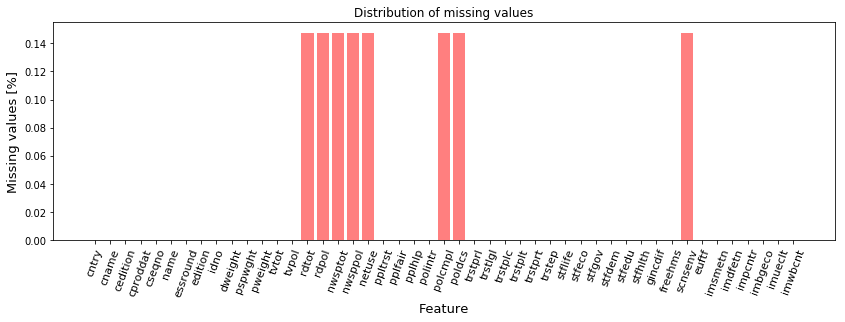

In [3]:
data = pd.read_csv("./resources/ESS1-7e01.csv")
Compose(FilterEssRound(7), plot_missing_values)(data)

### Discussion
* We have 8 features that conatain missing. 
* In a first step we just ignore these features in order to get fast results
* However, treating missing values properly should be done in the next iteration
* Furthermore we will ignore tuples (rows) that contain "ignorant" answers:
    - 66: Not applicable
    - 77: Refusal
    - 88: Don't know
    - 99: No answer     
* While these may contain important information, we ignore them for the moment in order to get a first analysis. 
* Thus, we need to interpret to following results as: "For people who gave meaningful answers"

In [7]:
columns_meta_data = ["cntry", "cname", "cedition", "cproddat", "cseqno", "name", "essround", 
                     "edition", "idno", "dweight", "pspwght", "pweight"]

# the result is a callable
data_preparer = Compose(FilterEssRound(7), 
                       drop_columns_containing_missings, 
                       assign_label, # assign labels 1/0 for finnland / germany
                       RemoveColumns(*columns_meta_data),
                       filter_ignorants)
df = data_preparer(data)

### How many categories per feature?

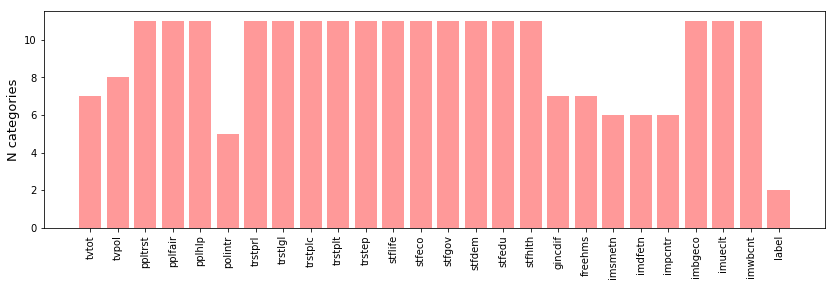

In [9]:
plot_number_of_categories(df)  


* Before we start, let's have a quick look at the number of categories we have (Plot above).
* They seem to be somewhat similar
* So, we don't expect to severe artifacts from that side

# Correlation Analysis

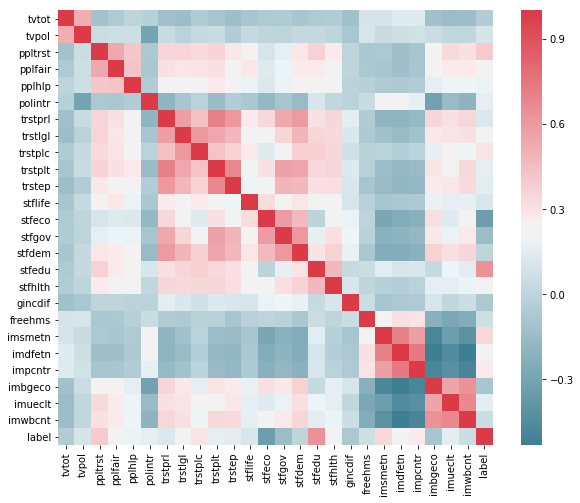

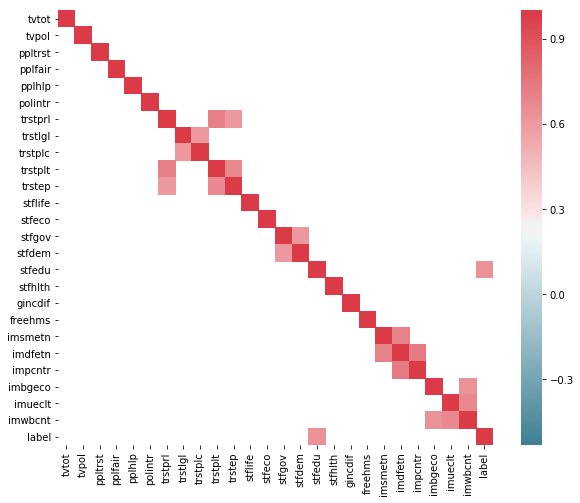

In [10]:
PlotCorrleation(method="spearman")(df)        
PlotCorrleation(method="spearman", threshold=0.6)(df)

### Discussion
* The above plot shows the Spearman correlation between the individual features (and an additional the feature "label" which represents if the questionaire participant was interviewed in Finnland or Germany)
* The lower plot shows only selected correlations where a threshold of the absolute value $>= 0.6$ was chosen ("strong correlation")
* Focosing on the lower plot, we see some relevant correlations (only positive correlations survive):


* **A strong correlation between trstplc (trust in police) and trstgl (trust in legal system)**
- This implies that people tend to have a similar opionion / consistent opionion on the legal system  and police.


* **A strong correlation between trstprl (trust in country's parliament), trstep (trust in the European Parliament), and trsplt (trust in politicians)**
- This implies that people tend to think similar / consistent about politicians, the parliament and the european parliament.


* **Furthermore we have  strong correlation between the features imwbcnt (Immigrants make country worse or better place to live) imueclt (Country's cultural life undermined or enriched by immigrants) and imbgeco (Immigration bad or good for country's economy)** 
- This implies that people think similar / consistent about these features. Interestingly, due to  the correlation between economy and cultural live people tend not to distinguish between these two concerns.


* **Finally, we have a strong correlation between the label and stfedu (State of education in country nowadays)**
- since this is the main question we are trying to answer, let's have a look at the distributions

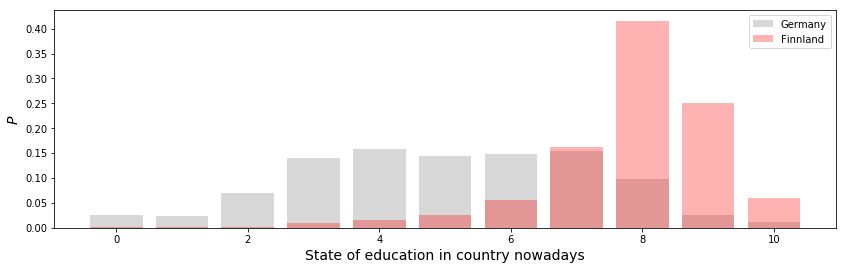

In [11]:
plot_country_vs_education(df)

### Discussion:
* We can see that Finnish people tend to judge their education system much higher than germans.
* Scale: 0-10 (extremely bad $\rightarrow$ extremely good)
* We have learned something!
* Now we go ahead and try to find some more insights with tree based methods

# Feature selection
* I will use a random forest classifier in order to find the most important features to discriminate between Finnland and Germany
* However, features importances from this method suffer from:
    - Prefers features with many categories (from the plot above this problem should not be too severe)
    - Correlated features: one is chosen randomly. The other one has reduced importance 

##### Gridsearch
* Let's make a quick, **not exhaustive** grid search in order to get a feeling for the random forest parameters:
* Use as scoring function the area under the ROC curve

In [12]:
X_train, X_test, Y_train, Y_test = get_test_train_size_split(df)

parameters = {'max_depth': [3, 5, 10, 20, 30, 50, 100], 
              'n_estimators' : [10,20,30,50,100, 200, 300]}
models = GridSearchCV(RandomForestClassifier(), parameters, cv=5, return_train_score=False, scoring='roc_auc')
models.fit(X_train, Y_train)
report(models.cv_results_)

Model with rank: 1
Mean validation score: 0.966 (std: 0.006)
Parameters: {'max_depth': 20, 'n_estimators': 300}

Model with rank: 2
Mean validation score: 0.965 (std: 0.006)
Parameters: {'max_depth': 30, 'n_estimators': 300}

Model with rank: 3
Mean validation score: 0.965 (std: 0.005)
Parameters: {'max_depth': 50, 'n_estimators': 300}

Model with rank: 4
Mean validation score: 0.965 (std: 0.005)
Parameters: {'max_depth': 100, 'n_estimators': 300}

Model with rank: 5
Mean validation score: 0.965 (std: 0.006)
Parameters: {'max_depth': 100, 'n_estimators': 200}

Model with rank: 6
Mean validation score: 0.965 (std: 0.006)
Parameters: {'max_depth': 20, 'n_estimators': 200}

Model with rank: 7
Mean validation score: 0.965 (std: 0.006)
Parameters: {'max_depth': 10, 'n_estimators': 300}

Model with rank: 8
Mean validation score: 0.964 (std: 0.005)
Parameters: {'max_depth': 50, 'n_estimators': 200}

Model with rank: 9
Mean validation score: 0.964 (std: 0.006)
Parameters: {'max_depth': 10, 'n_

In [13]:
# parameters from grid search - take max depth = 10 and 200 trees following Occam's Racor
rf = RandomForestClassifier(max_depth=10, n_estimators=300) 
rf.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

**Performance on test set**

prediction,0,1
reality,,
0,492,42
1,47,297


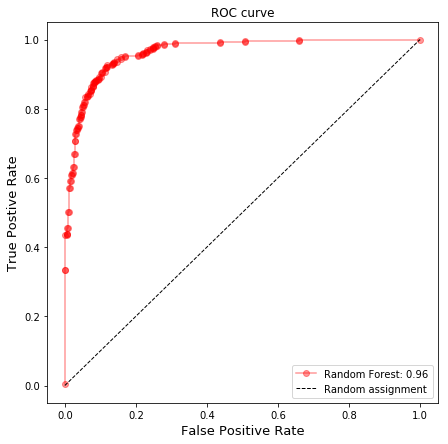

In [14]:
display(get_confusion_matrix(Y_test, rf.predict(X_test)))
Compose(ComputeRoc(X_test, Y_test), plot_roc_curve)(rf)

In [15]:
display(Markdown("**Compare to Baseline = most frequent label**"))
baseline_prediction = Y_train.value_counts().idxmax()
get_confusion_matrix(Y_test, baseline_prediction * np.ones(shape=Y_test.size))

**Compare to Baseline = most frequent label**

prediction,0.0
reality,
0,534
1,344


**Feature Importance**

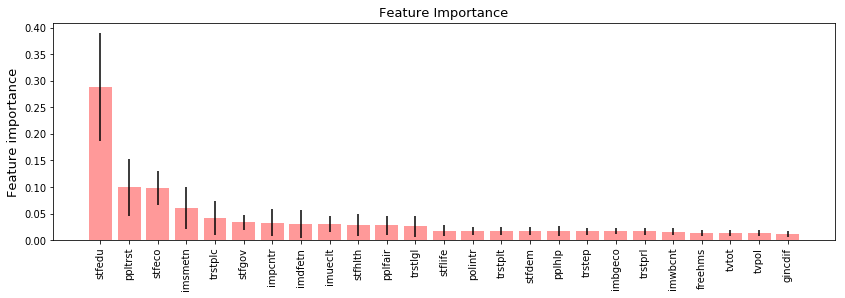

In [16]:
Compose(GetFeatureImportance(X_train.columns), plot_feature_importance)(rf)

### Discussion

### Prediction quality:
* The given features are very predictive 
* We have an area under the roc curve of about 0.96 (we predict about 90% correct)
* In comparison the baseline model (i.e. assign each label the most frequent / german one) get about 60 % correct
* But for the time beeing we are not really interested in the random forest itself, but we would rather use it for feature selection


### Feature selection based on random forest:
* From the Random forest we can say that the 3 most important features are:
- sftedu: "State of education in country nowadays"
0-10 (extremely bad $\rightarrow$ extremely good)
- ppltrst: "Most people can be trusted or you can't be too careful"
    0-10 (can't be too careful $\rightarrow$ most people can be trusted)
- stfeco: "State of education in country nowadays"
    0-10 (extremely bad $\rightarrow$ extremely good)

# The  Stereotype Model
* We now take these features and build a very simple decision tree
* By simple we mean a very shallow tree (i.e. with depth=2)
* This will have less predictive power, but is easier to interpret

In [17]:
def plot_tree_structure(model, columns, class_names=["DE", "FI"]):
    dot = tree.export_graphviz(model, 
                     out_file=None, 
                     feature_names=columns,  
                     class_names=["DE", "FI"],  
                     proportion=True,
                     filled=False, 
                     rounded=True, node_ids=True)  
    return graphviz.Source(dot) 

In [18]:
# Prepare data from scratch in order to avoid side effects
data_preparer = Compose(FilterEssRound(7), 
                       drop_columns_containing_missings, 
                       assign_label, 
                       RemoveColumns(*columns_meta_data),
                       SelectColumns("stfedu", "stfeco", "ppltrst", "label"),
                       filter_ignorants)
df = data_preparer(data)
X_train, X_test, Y_train, Y_test = get_test_train_size_split(df)
dt = DecisionTreeClassifier(max_depth=2, class_weight="balanced").fit(X_train, Y_train)

### Quality of the model:

**Confustion matrix and Roc curve over the Test Set**

prediction,0,1
reality,,
0,512,99
1,86,302


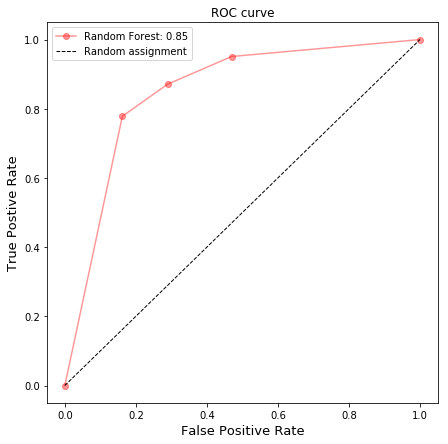

In [19]:
display(Markdown("**Confustion matrix and Roc curve over the Test Set**"))
display(get_confusion_matrix(Y_test, dt.predict(X_test)))
Compose(ComputeRoc(X_test, Y_test), plot_roc_curve)(dt)

* The model is worse than the random forest (sure!)
* But its not awefully bad (from the confusion matrix we see that we about 80 %  right)
* We take this approximation into account. Stereotypes are never precise!
* Let's go ahead and look at the tree structure for this model

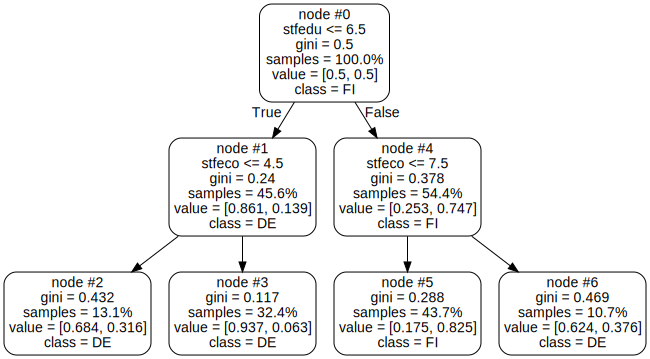

In [20]:
plot_tree_structure(dt, X_train.columns)

### Discussion 
* The purest (i.e., lowest gini score) nodes are node 3 and node 5:
* They allow the following interpretation

1. **Germans are less happy with their educational system but happier with ther economy** (Node 3)
2. **Contrary: finnish peoply are happier with their educational system but less happy with their economy** (Node 5)

Furthermore node 2 and node 6 show the tendency: 
1. **German angst**: If you are unhappy with both, the educational system and the economic system then you are probably german (node 2)
2. **German elite**: If you are happy with both the educational system and the economic system then you are probably also german (node 6)

These two nodes can than be interpreted as a segregation of german society 


**Note** 
* We took data from ESS round 7 (2014)
* This probably explains many of the economic effects (Germany did pretty well during the crisis, in Finnland there was the Nokia accident)
* Thus it would be interesting to look at other rounds and look at time series.
* Also note that for this very shallow tree the feature ppltrst is not even considered by the tree

Finally let's look a little bit deeper into the result by plotting the decision boundary

# Decision boundaries
*  In the following we will look at decision boundaries for
1. The simple stereotyp model form above (using only features the relavant features "stfedu", "stfeco")
2. Using these two features, a deeper decision tree 

In [21]:
reduced_x_train = SelectColumns("stfedu", "stfeco")(X_train)

In [22]:
# finiding deeper tree
parameters = {'max_depth': np.arange(1, 10)}
trees = GridSearchCV(DecisionTreeClassifier(), parameters, cv=5, return_train_score=False, scoring='roc_auc')
trees.fit(reduced_x_train, Y_train)
report(trees.cv_results_)

Model with rank: 1
Mean validation score: 0.911 (std: 0.005)
Parameters: {'max_depth': 7}

Model with rank: 2
Mean validation score: 0.911 (std: 0.005)
Parameters: {'max_depth': 9}

Model with rank: 3
Mean validation score: 0.911 (std: 0.005)
Parameters: {'max_depth': 8}

Model with rank: 4
Mean validation score: 0.911 (std: 0.005)
Parameters: {'max_depth': 6}

Model with rank: 5
Mean validation score: 0.911 (std: 0.004)
Parameters: {'max_depth': 5}

Model with rank: 6
Mean validation score: 0.905 (std: 0.005)
Parameters: {'max_depth': 4}

Model with rank: 7
Mean validation score: 0.889 (std: 0.008)
Parameters: {'max_depth': 3}

Model with rank: 8
Mean validation score: 0.858 (std: 0.007)
Parameters: {'max_depth': 2}

Model with rank: 9
Mean validation score: 0.786 (std: 0.008)
Parameters: {'max_depth': 1}



### Sterotype model (depth=2)

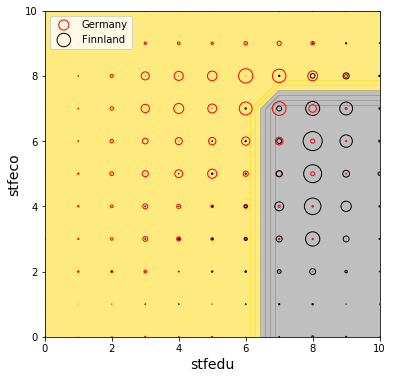

In [26]:
model = DecisionTreeClassifier(max_depth=2, class_weight="balanced").fit(reduced_x_train, Y_train)
plot_decision_boundary(model=model, x=reduced_x_train, y=Y_train)

###  A deeper tree with depth=6

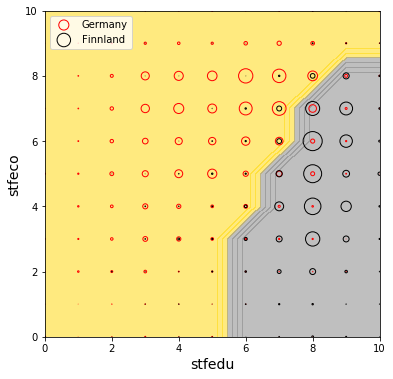

In [25]:
model = DecisionTreeClassifier(max_depth=6, class_weight="balanced").fit(reduced_x_train, Y_train)
plot_decision_boundary(model=model, x=reduced_x_train, y=Y_train)

### Discussion

* Plotted are the decision boundaries (yellow = Germany, grey=Finnland)
* The red circles are german answers, where the size of the circle is proportional to the frequency in the data
* The black circles are finnish answers, again with their seize beeing proportional to the frequency

* The stereotype model just reflect the discussion above: 
* Finnish people are happier with the educational system but leave some place for the "german elite"

* In a more complex model (depth=6) this picture rougly remains the same. 
* However the picture gets refined
* In an intermediate region there is  roughly a linear decision boundary where beeing happier with the educational system goes in line with the satisfaction on economics.  


### Outlook
* Looking at the last plot, there seems to be rather a linear behaviour. Thus it would be interesting to use simple models (e.g. linear or quadratic discriminant analysis) to find sterotype models, as the decision boundary does not really seem to be parallel to the f
* Having established a sterotype model, it is interesting how accurately we can determine wheter someone is finish or germin